In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import financial.data as fd
import financial.model as fm
import financial.portfolio as fp
import financial.strategies.simulation as fss
from financial.io.file.cache import FileCache
from financial.io.cache import AppendStrategy
from financial.io.file.model import FileModelProvider

import os
from dotenv import load_dotenv
from financial.momentum.utilities import find_dotenv
from financial.momentum.experiment.modelExperiment import ModelExperimentFactory

In [33]:
load_dotenv(dotenv_path=find_dotenv())

cache = os.environ["CACHE"] + "/"
model = os.environ["MODEL"]

ds = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=cache))
mp = FileModelProvider(model_path=model)
mc = fm.ModelCache(ds, mp, cache=FileCache(update_strategy=AppendStrategy(), cache_path=model))
uc = fm.UnifiedCache(ds, mc)

In [9]:
import financial.lab.models as labmodels
import sklearn.linear_model

class LinearScikitLearnModelFactory (labmodels.ModelFactory):
    '''
    Linear regression Scikit-Learn model factory
    '''
        
    def create_model_from_descriptors(self, 
                                      model_id: str, 
                                      hyperparameters: dict, 
                                      input_descriptor: fd.DataDescriptor, 
                                      output_descriptor: fd.DataDescriptor) -> fm.Model:
        model = sklearn.linear_model.LinearRegression()
        return fm.ScikitLearnModel(model_id, input_descriptor, output_descriptor, model, hyperparameters)
        

factory = LinearScikitLearnModelFactory()

In [16]:
start_date = "1990-01-01"
end_date = "2023-12-31"
universe_spdr_us = ['XLE', 'XLB', 'XLI', 'XLY', 'XLP', 'XLV', 'XLF', 'XLK', 'XLU', 'XSD'] # XLC XLRE out
for ticker in universe_spdr_us:
    config = {
        "mode": "global",
        "datastore": ds,
        "ticker": ticker,
        "model_factory": factory,
        "name": "scikit-learn_linearRegresion" + "_" + ticker,
        "start_year": start_date,
        "end_year": end_date
    }
    experiment_linear = ModelExperimentFactory.create_experiment(config)
    data = ds.get_data(ticker, start_date, end_date)
    if len(data) < 90:
        print(f"[{ticker}] Skipped: not enough data ({len(data)} rows)")
        continue
    experiment_linear.run()
    print(ticker)

XLE
XLB
XLI
XLY
XLP
XLV
XLF
XLK
XLU
XSD


In [35]:
from financial.momentum.indicators.modelIndicator import ModelIndicator
simulation_indicator = ModelIndicator("scikit-learn_linearRegresion")

In [36]:
import financial.strategies.allocation as fsa
import financial.strategies.filter as fsf
import financial.strategies.rank as fsr

simulation_filter = fsf.CompositeAssetFilter( [fsf.TopKAssetFilter(k=4), fsf.MinimumValueAssetFilter(threshold=0.0)] )
simulation_allocation = fsa.FixedWeightAllocation(0.10)
simulation_strategy = fsr.AssetRankingStrategy("Simulation", universe_spdr_us, simulation_indicator, simulation_filter, simulation_allocation)
print(simulation_strategy)

Simulation
- 10 asset universe: ['XLE', 'XLB', 'XLI', 'XLY', 'XLP', 'XLV', 'XLF', 'XLK', 'XLU', 'XSD']
- Indicator: {'type': 'financial.momentum.indicators.modelIndicator.ModelIndicator'}


In [37]:
%%time
import financial.strategies.rebalance as fsrebalance

strategy_simulation = "simulation"
strategy = simulation_strategy
benchmark = fp.BenchmarkPortfolio("^GSPC")
market = ds.get_data("^GSPC")
rebalancing = fsrebalance.MonthlyRebalancingSchedule(-1,market) # +1 first day, -1 last day, +2 second day with 1st day momentum

print("STRATEGY")
print(strategy)
print("BENCHMARK")
print(benchmark)
print("REBALANCING")
print(rebalancing)

simulation = fss.StockStrategySimulation(uc, strategy, rebalancing, market)
simulation.verbose = True  # verbose 41.7s vs. 27s without trading details
simulation_start_year = 2001
simulation_end_year = 2023
simulation.simulate(start_year=simulation_start_year, end_year=simulation_end_year)

STRATEGY
Simulation
- 10 asset universe: ['XLE', 'XLB', 'XLI', 'XLY', 'XLP', 'XLV', 'XLF', 'XLK', 'XLU', 'XSD']
- Indicator: {'type': 'financial.momentum.indicators.modelIndicator.ModelIndicator'}
BENCHMARK
^GSPC(^GSPC)
REBALANCING
Rebalancing schedule: Monthly rebalancing on -1
INITIAL PORTFOLIO
Stocks: ['$$$']
Portfolio value: 1000000.00
Portfolio assets: {'$$$': 1000000.0}
Portfolio stocks: {'$$$': 1000000}
Portfolio weights: {'$$$': 1.0}
+ Rebalance @ 2001-01-30
- Portfolio value: $1000000.00
{'XLK': 0.1, 'XLF': 0.1, '$$$': 0.8}
+ Trade @ 2001-01-31
- Changes: {'XLF': 4182, '$$$': -199944.71339797974, 'XLK': 2680}
- Rotation: 19.99%
Before $1000000.00:
- Stocks: {'$$$': 1000000}
- Assets: {'$$$': 1000000.0}
Selling $$$: -199944.71x$1.00 = $-199944.71
Buying XLF: 4182.00x$23.91 = $99980.72
Buying XLK: 2680.00x$37.30 = $99964.00
After $1000000.00:
- Stocks: {'$$$': 1000000, 'XLF': 0, 'XLK': 0}
- Assets: {'$$$': 1000000.0, 'XLF': 0.0, 'XLK': 0.0}
+ Rebalance @ 2001-02-27
- Portfolio v

In [38]:
year_returns = simulation.year_returns()

print("\nSTRATEGY RETURNS")
for year in year_returns:
    print(f"{year}: {100*year_returns[year]:6.2f}%")


cumulative = simulation.cumulative_returns(year_returns)

print("\nCUMULATIVE RETURNS")
for year in cumulative:
    print(f"{year}: {100*cumulative[year]:6.2f}%")



STRATEGY RETURNS
2001:  -4.74%
2002:  -1.93%
2003:   1.25%
2004:   3.16%
2005:  -0.50%
2006:   5.21%
2007:  -1.60%
2008: -10.30%
2009:   0.12%
2010:  -3.00%
2011:  -0.56%
2012:   3.96%
2013:   5.95%
2014:   5.80%
2015:  -4.88%
2016:   4.58%
2017:   1.49%
2018:  -3.95%
2019:   7.34%
2020:   7.45%
2021:   5.42%
2022:  -7.82%
2023:   9.00%

CUMULATIVE RETURNS
2001:  -4.74%
2002:  -6.57%
2003:  -5.41%
2004:  -2.42%
2005:  -2.90%
2006:   2.16%
2007:   0.52%
2008:  -9.83%
2009:  -9.72%
2010: -12.43%
2011: -12.92%
2012:  -9.47%
2013:  -4.08%
2014:   1.48%
2015:  -3.47%
2016:   0.95%
2017:   2.45%
2018:  -1.60%
2019:   5.62%
2020:  13.50%
2021:  19.64%
2022:  10.29%
2023:  20.21%


In [39]:
simulation.simulation_year_report()

2001
- Cost:  $1000000.00
- Value: $ 952617.15
- Gain:  $ -47382.85   -4.74%
2002
- Cost:  $1000000.00
- Value: $ 934253.30
- Gain:  $ -65746.70   -6.57%
2003
- Cost:  $1000000.00
- Value: $ 945898.49
- Gain:  $ -54101.51   -5.41%
2004
- Cost:  $1000000.00
- Value: $ 975802.94
- Gain:  $ -24197.06   -2.42%
2005
- Cost:  $1000000.00
- Value: $ 970959.71
- Gain:  $ -29040.29   -2.90%
2006
- Cost:  $1000000.00
- Value: $1021576.19
- Gain:  $  21576.19    2.16%
2007
- Cost:  $1000000.00
- Value: $1005241.14
- Gain:  $   5241.14    0.52%
2008
- Cost:  $1000000.00
- Value: $ 901739.32
- Gain:  $ -98260.68   -9.83%
2009
- Cost:  $1000000.00
- Value: $ 902819.98
- Gain:  $ -97180.02   -9.72%
2010
- Cost:  $1000000.00
- Value: $ 875718.79
- Gain:  $-124281.21  -12.43%
2011
- Cost:  $1000000.00
- Value: $ 870801.42
- Gain:  $-129198.58  -12.92%
2012
- Cost:  $1000000.00
- Value: $ 905327.86
- Gain:  $ -94672.14   -9.47%
2013
- Cost:  $1000000.00
- Value: $ 959179.65
- Gain:  $ -40820.35   -4.08%

In [41]:
import financial.portfolios.statistics as fps
assets = {'^GSPC': 1.0}
target = fp.WeightedPortfolio.from_assets("Target", assets)
benchmark_returns = target.returns(ds,'2015-12-31','2023-12-31')
benchmark_monthly_returns = fss.SimulationUtilities.monthly_returns(ds,target,2016,2023)
benchmark_cumulative_returns = fps.CumulativeReturn().get_series(benchmark_monthly_returns)

In [47]:
benchmark_monthly_returns = fss.SimulationUtilities.monthly_returns(ds,target,simulation_start_year,simulation_end_year)
benchmark_cumulative_returns = fps.CumulativeReturn().get_series(benchmark_monthly_returns)
fss.SimulationReport.simulation_report(benchmark_monthly_returns, fss.accumulate_return)

          TOTAL     YEAR     Jan     Feb     Mar     Apr     May     Jun     Jul     Aug     Sep     Oct     Nov     Dec
  2001:  -10.53%  -10.53%   6.45%  -9.23%  -6.42%   7.68%   0.51%  -2.50%  -1.07%  -6.41%  -8.17%   1.81%   7.52%   0.76%
  2002:  -31.44%  -23.37%  -1.56%  -2.08%   3.67%  -6.14%  -0.91%  -7.25%  -7.90%   0.49% -11.00%   8.64%   5.71%  -6.03%
  2003:  -13.35%   26.38%  -2.74%  -1.70%   0.84%   8.10%   5.09%   1.13%   1.62%   1.79%  -1.19%   5.50%   0.71%   5.08%
  2004:   -5.56%    8.99%   1.73%   1.22%  -1.64%  -1.68%   1.21%   1.80%  -3.43%   0.23%   0.94%   1.40%   3.86%   3.25%
  2005:   -2.73%    3.00%  -2.53%   1.89%  -1.91%  -2.01%   3.00%  -0.01%   3.60%  -1.12%   0.69%  -1.77%   3.52%  -0.10%
  2006:   10.52%   13.62%   2.55%   0.05%   1.11%   1.22%  -3.09%   0.01%   0.51%   2.13%   2.46%   3.15%   1.65%   1.26%
  2007:   14.42%    3.53%   1.41%  -2.18%   1.00%   4.33%   3.25%  -1.78%  -3.20%   1.29%   3.58%   1.48%  -4.40%  -0.86%
  2008:  -29.61%  -38.49%

In [51]:
rotation = simulation.monthly_rotation()
print(f"Average monthly rotation: {100*rotation:.2f}%")

Average monthly rotation: 23.19%


In [52]:
year_returns = simulation.year_returns()
#print(year_returns)

print("\nSTRATEGY RETURNS")
for year in year_returns:
    print(f"{year}: {100*year_returns[year]:6.2f}%")


cumulative = simulation.cumulative_returns(year_returns)

print("\nCUMULATIVE RETURNS")
for year in cumulative:
    print(f"{year}: {100*cumulative[year]:6.2f}%")


STRATEGY RETURNS
2001:  -4.74%
2002:  -1.93%
2003:   1.25%
2004:   3.16%
2005:  -0.50%
2006:   5.21%
2007:  -1.60%
2008: -10.30%
2009:   0.12%
2010:  -3.00%
2011:  -0.56%
2012:   3.96%
2013:   5.95%
2014:   5.80%
2015:  -4.88%
2016:   4.58%
2017:   1.49%
2018:  -3.95%
2019:   7.34%
2020:   7.45%
2021:   5.42%
2022:  -7.82%
2023:   9.00%

CUMULATIVE RETURNS
2001:  -4.74%
2002:  -6.57%
2003:  -5.41%
2004:  -2.42%
2005:  -2.90%
2006:   2.16%
2007:   0.52%
2008:  -9.83%
2009:  -9.72%
2010: -12.43%
2011: -12.92%
2012:  -9.47%
2013:  -4.08%
2014:   1.48%
2015:  -3.47%
2016:   0.95%
2017:   2.45%
2018:  -1.60%
2019:   5.62%
2020:  13.50%
2021:  19.64%
2022:  10.29%
2023:  20.21%


In [53]:
%%time

year = 2016
monthly_returns = simulation.monthly_returns(year)
cumulative_returns = simulation.cumulative_returns(monthly_returns)
year_return = cumulative_returns[12]

print("Monthly returns")
returns_str = [f"{100*month_return:>6.2f}%" for month_return in monthly_returns.values()]
print(f"  {year}:           {100*year_return:>6.2f}% " + " ".join(returns_str))

print("Monthly cumulative returns")
returns_str = [f"{100*month_return:>6.2f}%" for month_return in cumulative_returns.values()]
print(f"  {year}:           {100*year_return:>6.2f}% " + " ".join(returns_str))

print()
print("SERIES")
print("Monthly returns")
monthly_returns = simulation.returns()
print(monthly_returns)
cumulative_returns = fps.CumulativeReturn().get_series(monthly_returns)
print("Cumulative returns")
print(cumulative_returns)

Monthly returns
  2016:             4.58%  -0.37%  -0.09%   3.08%   1.45%   0.05%   0.08%   0.48%  -0.30%   0.09%   0.00%   0.00%   0.05%
Monthly cumulative returns
  2016:             4.58%  -0.37%  -0.46%   2.61%   4.10%   4.15%   4.24%   4.75%   4.43%   4.53%   4.53%   4.53%   4.58%

SERIES
Monthly returns
Series([], Name: return, dtype: float64)
Cumulative returns
Series([], Name: return, dtype: float64)
CPU times: user 21.7 s, sys: 21.8 ms, total: 21.7 s
Wall time: 21.7 s


In [48]:
drawdown = fps.MaximumDrawdown().get_series(monthly_returns)
print(drawdown)
print(f"Maximum drawdown: {100*min(drawdown):.3f}%")

volatility = fps.DailyVolatility().get(monthly_returns)
print(f"Volatility: {100*volatility:.3f}%")

sharpe = fps.SharpeRatio().get(monthly_returns)
print(f"Sharpe ratio: {sharpe:.4f}")

sortino = fps.SortinoRatio().get(monthly_returns)
print(f"Sortino ratio: {sortino:.4f}")

Series([], Name: return, dtype: float64)


ValueError: min() iterable argument is empty

<Axes: >

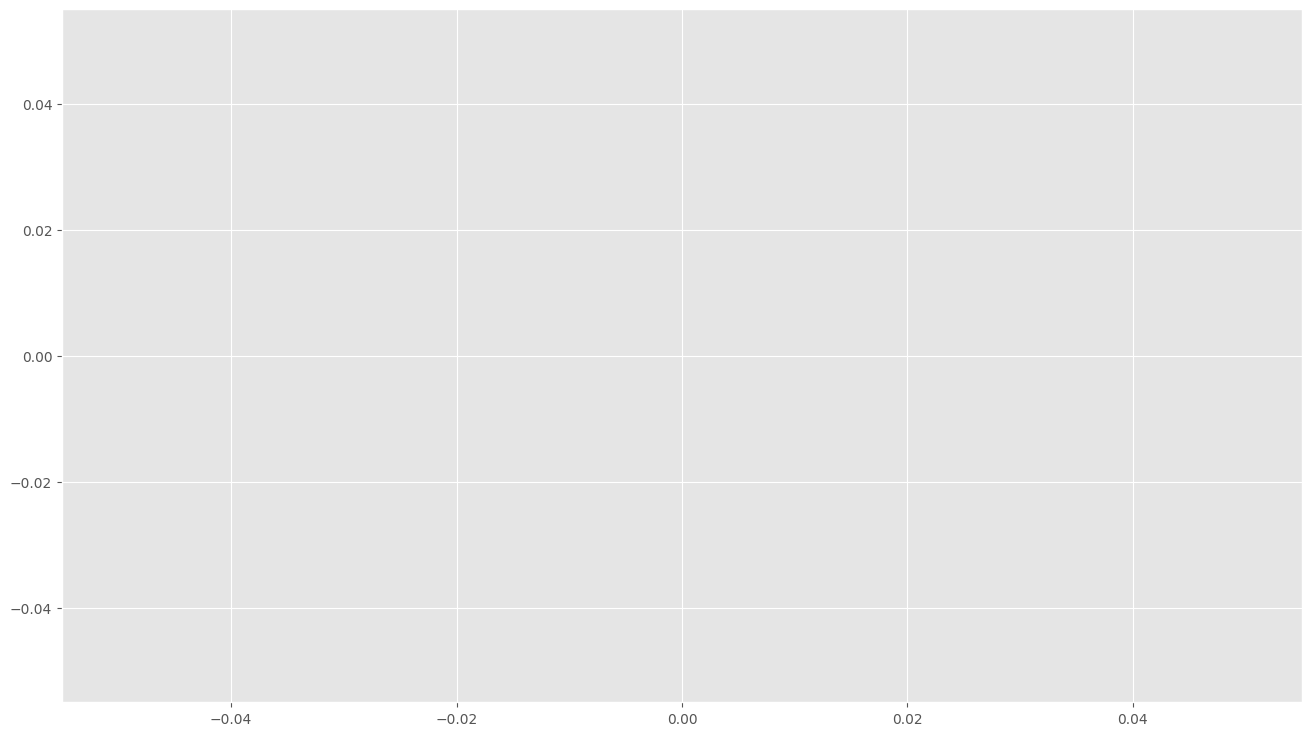

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl

mpl.rc('figure', figsize=(16, 9))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

fig = plt.figure()

benchmark = 100*benchmark_cumulative_returns
#benchmark = 100*fps.MaximumDrawdown().get_series(benchmark_monthly_returns)

data = 100*cumulative_returns
#data = 100*drawdown

#monthly_returns.plot(label=ticker)
data.plot()
benchmark.plot()